In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
import ipynbname
from endaaman.ml import fix_global_seed

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)


sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 

os.makedirs('out/figs', exist_ok=True)

fix_global_seed()

print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))

DPI = 600
device = 'cuda'

In [2]:
model = timm.create_model('hf-hub:MahmoodLab/uni', pretrained=True, init_values=1e-5)
model.blocks[-1]
num_layers = len(model.blocks)

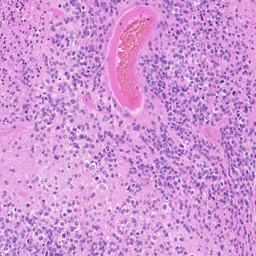

In [3]:
image = Image.open('../data/misc/19-0420_04_crop.png').convert('RGB')
display(image.resize((256, 256)))

In [4]:
model = model.to(device)
model.eval()  # モデルを評価モードに設定

# 画像の前処理
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = preprocess(image).unsqueeze(0).to(device)

feature_maps = []
    
def hook_fn(module, input, output):
    feature_maps.append(output.detach())  # detach()を使用してメモリリークを防ぐ

hooks = []
# 各ブロックのattentionレイヤーにフックを登録
for block in model.blocks:
    hooks.append(block.attn.register_forward_hook(hook_fn))

# モデルに入力を通す
with torch.no_grad():
    _ = model(img)

# 特徴量マップのリサイズと結合
resized_maps = []
for feature_map in feature_maps:
    # クラストークンを除外 (1, 197, 1024) -> (1, 196, 1024)
    feature_map = feature_map[:, 1:, :]
    
    # 特徴量マップを2D形状に変形 (1, 196, 1024) -> (1, 1024, 14, 14)
    feature_map_2d = feature_map.reshape(1, 14, 14, -1).permute(0, 3, 1, 2)
    
    # 224x224にリサイズ
    resized_map = resize(feature_map_2d, (224, 224), antialias=False)
    resized_maps.append(resized_map)

# すべての層の特徴量マップを結合
feature_map = torch.cat(resized_maps, dim=1)  # 1 x (num_layers * 1024) x 224 x 224

print('attention')
print(feature_map.shape)
feature_map = feature_map.detach().cpu().squeeze().numpy()
feature_map = np.mean(feature_map.reshape(num_layers, -1, 224, 224), axis=1)

attention
torch.Size([1, 24576, 224, 224])


(24, 224, 224)
[[<Axes: title={'center': 'Original Image'}> <Axes: > <Axes: > <Axes: >
  <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]]
24
0 1 0
0 2 1
0 3 2
0 4 3
1 0 4
1 1 5
1 2 6
1 3 7
1 4 8
2 0 9
2 1 10
2 2 11
2 3 12
2 4 13
3 0 14
3 1 15
3 2 16
3 3 17
3 4 18
4 0 19
4 1 20
4 2 21
4 3 22
4 4 23


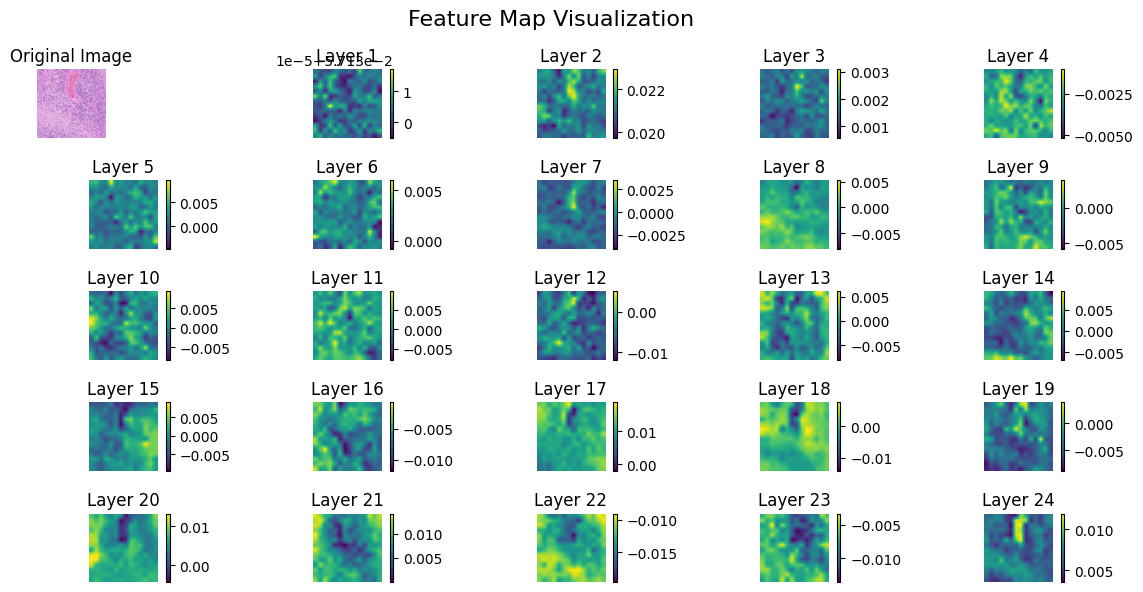

In [15]:
import math
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img = img_transform(image)

# 特徴量マップを処理


print(feature_map.shape)

# プロットの準備

fig, axs = plt.subplots(math.ceil(num_layers/5), 5, figsize=(12, 6))
fig.suptitle("Feature Map Visualization", fontsize=16)

# 元の画像を表示
axs[0, 0].imshow(img.permute(1, 2, 0))
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')
print(axs)
print(num_layers)
# 各レイヤーの特徴量マップを表示
for i in range(num_layers):
    row = (i+1) // 5
    col = (i+1) % 5
    print(row, col, i)
    im = axs[row, col].imshow(feature_map[i], cmap='viridis', interpolation='nearest')
    axs[row, col].set_title(f"Layer {i+1}")
    axs[row, col].axis('off')
    fig.colorbar(im, ax=axs[row, col], fraction=0.046, pad=0.04)

# 余白の調整
plt.tight_layout()
plt.show()

In [ ]:

def get_patch_features(image, model, device='cuda'):
    original_size = image.width
    # 画像の前処理
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = preprocess(image).unsqueeze(0).to(device)

    # モデルの準備
    model = model.to(device)
    model.eval()

    # フックの定義
    features = {}
    def hook_fn(module, input, output):
        features['embedding'] = output

    # 最後のTransformerブロックにフックを登録
    model.blocks[-1].register_forward_hook(hook_fn)

    # 順伝播
    with torch.no_grad():
        _ = model(img)

    # 特徴量の取得と整形
    patch_embeddings = features['embedding'][0]
    h = w = int((patch_embeddings.shape[0] - 1) ** 0.5)
    patch_features = patch_embeddings[1:].reshape(h, w, -1)
    #     # 特徴量を元の画像サイズにリサイズ
    # resized_features = torch.nn.functional.interpolate(
    #     patch_features.permute(2, 0, 1).unsqueeze(0), 
    #     size=original_size, 
    #     mode='bilinear', 
    #     align_corners=False
    # )
    # resized_features = resized_features.squeeze(0).permute(1, 2, 0)
    # return resized_features
    return patch_features



# 特徴量の抽出
patch_features = get_patch_features(image, model)

print(f"特徴量のシェイプ: {patch_features.shape}")

In [ ]:

def apply_pca_and_resize(features, target_size):
    # 特徴量を2Dに変形
    features_2d = features.reshape(-1, features.shape[-1])

    # PCAの適用
    pca = PCA(n_components=3)
    features_pca = pca.fit_transform(features_2d.cpu().numpy())

    # 3チャンネルの特徴マップに戻す
    features_pca = features_pca.reshape(14, 14, 3)

    # NumPy配列をPyTorchテンソルに変換
    features_pca_tensor = torch.from_numpy(features_pca).float().unsqueeze(0).permute(0, 3, 1, 2)

    # 元の画像サイズにリサイズ
    resized_features = torch.nn.functional.interpolate(
        features_pca_tensor, 
        size=target_size, 
        mode='bilinear', 
        align_corners=False
    )

    return resized_features.squeeze(0).permute(1,2,0)


pca_image = apply_pca_and_resize(patch_features, image.width)
a = (pca_image.numpy() * 255).astype(np.uint8)
display(Image.fromarray(a))